In [ ]:
import time
def lcm(a, b):
    return a * b // xgcd(a,b)[0]

def xgcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = xgcd(b % a, a)
        return (g, x - (b // a) * y, y)

def multiplicative_inverse(a, modulus):
    g, x, y = xgcd(a, modulus)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % modulus


def binary_exponent(base, exponent, modulus):
    if modulus == 1:
        yield 0
        return
    bitmask = 1 << exponent.bit_length() - 1
    res = 1
    while bitmask:
        res = (res * res) % modulus
        if bitmask & exponent:
            res = (res * base) % modulus
        yield res
        bitmask >>= 1

In [ ]:
import random

def is_probably_prime(n):
    tests = max(128, n.bit_length())
    for i in range(tests):
        rand = random.randint(1,n-1)
        return 1 in binary_exponent(rand, n-1, n)

def generate_prime(bitlen=128):
    n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    while not is_probably_prime(n):
        n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    return n

In [3]:
import random

class PrivateKey: 
    def __init__(self, p, q, n):
        self.ld = lcm( p-1, q-1)
        self.mu = multiplicative_inverse( self.ld, n)
        
    def __repr__(self):
        return ("---\nPrivate Key :\nλ:\t"+str(self.ld) +"\nμ:\t"+str(self.mu) +"\n---")


class PublicKey:
    def __init__(self, n):
        self.n = n
        self.nsq = n * n
        self.g = n+1
    
    def __repr__(self):
        return ("---\nPublic Key :\nn:\t"+ str(self.n) +"\n---")


def generate_keys(bitlen=128):
    p = generate_prime(bitlen)
    q = generate_prime(bitlen)
    n = p * q
    return (PublicKey(n), PrivateKey(p, q, n))


def Encrypt(public_key, plaintext):
    r = random.randint( 1, public_key.n-1)
    while not xgcd( r, public_key.n)[0] == 1:
        r = random.randint( 1, public_key.n)
        
    a = pow(public_key.g, plaintext, public_key.nsq)
    b = pow(r, public_key.n, public_key.nsq)
    
    ciphertext = (a * b) % public_key.nsq
    return ciphertext

def Decrypt(public_key, private_key, ciphertext):
    x = pow(ciphertext, private_key.ld, public_key.nsq)
    L = lambda x: (x - 1) // public_key.n
    
    plaintext = (L(x) * private_key.mu) % public_key.n 
    return plaintext


def homomorphic_add(public_key, a, b):
    return (a * b) % public_key.nsq

def homomorphic_mult(public_key, a, b):
    return pow(a, b, public_key.nsq)

In [4]:
from PIL import Image
import numpy as np
import pickle

def ImgEncrypt(public_key, plainimg):
    cipherimg = np.asarray(plainimg)
    shape = cipherimg.shape
    cipherimg = cipherimg.flatten().tolist()
    cipherimg = [Encrypt(public_key, pix) for pix in cipherimg]
    
    return np.asarray(cipherimg).reshape(shape)


def ImgDecrypt(public_key, private_key, cipherimg):
    shape = cipherimg.shape
    plainimg = cipherimg.flatten().tolist()
    plainimg = [Decrypt(public_key, private_key, pix) for pix in plainimg]
    plainimg = [pix if pix < 255 else 255 for pix in plainimg]
    plainimg = [pix if pix > 0 else 0 for pix in plainimg]
    
    return np.asarray(plainimg).reshape(shape)


def homomorphicBrightness(public_key, cipherimg, factor):
    shape = cipherimg.shape
    brightimg = cipherimg.flatten().tolist()
    factor = Encrypt(public_key, factor)
    brightimg = [homomorphic_add(public_key, factor, pix) for pix in brightimg]
    
    return np.asarray(brightimg).reshape(shape)

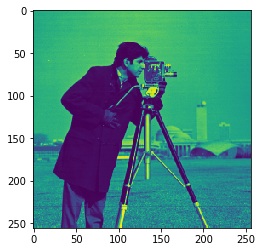

In [6]:
import cv2
import matplotlib.pyplot as plt
img_bgr = cv2.imread('camera.png', 0)
plt.imshow(img_bgr)

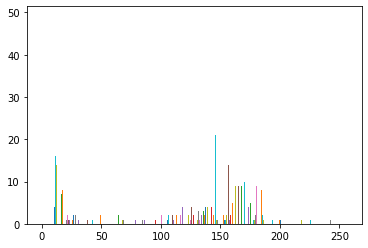

In [7]:
plt.hist(img_bgr,256,[0,256])
plt.show()

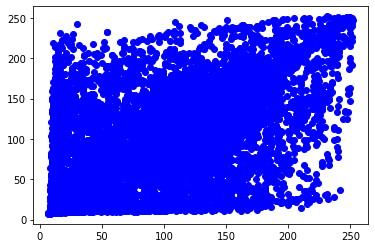

In [9]:
#Horizontal Correlation
x = []
y = []
for i in range(0,256):
    for j in range(0,255):
        x.append(img_bgr[i][j])
        y.append(img_bgr[i][j+1])
plt.plot(x,y,'bo')

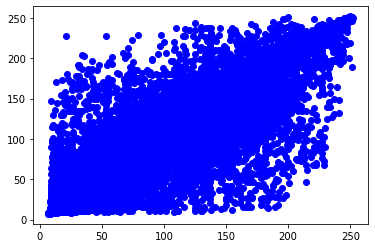

In [10]:
#Vertical correlation
vx = []
vy = []
for i in range(0,255):
    for j in range(0,256):
        vx.append(img_bgr[i][j])
        vy.append(img_bgr[i+1][j])
plt.plot(vx,vy,'bo')

In [11]:
publickey, privatekey = generate_keys()

In [12]:
start_time = time.time()
encImg = ImgEncrypt(publickey, img_bgr)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))

--- 80.9078209400177 seconds ---


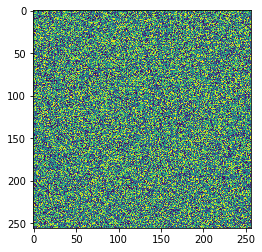

In [13]:
plt.imshow(encImg.astype(np.float))

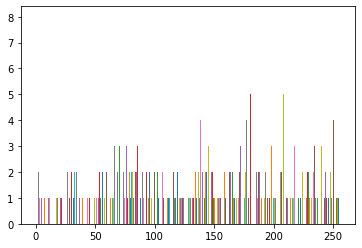

In [14]:
plt.hist(encImg%256,256,[0,256])
plt.show()

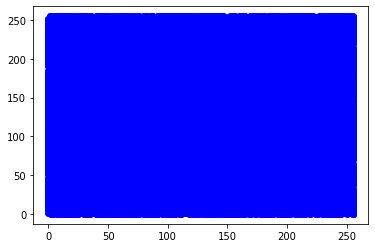

In [16]:
#Horizontal correlation 
x1 = []
y1 = []
for i in range(0,256):
    for j in range(0,255):
        x1.append(encImg[i][j]%256)
        y1.append(encImg[i][j+1]%256)
plt.plot(x1,y1,'bo')

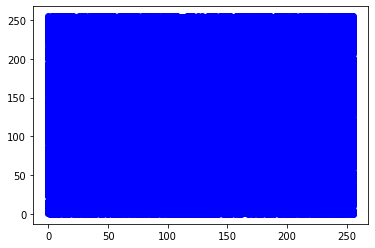

In [18]:
#Vertical correlation
v1 = []
v2 = []
for i in range(0,255):
    for j in range(0,256):
        v1.append(encImg[i][j]%256)
        v2.append(encImg[i+1][j]%256)
plt.plot(v1,v2,'bo')

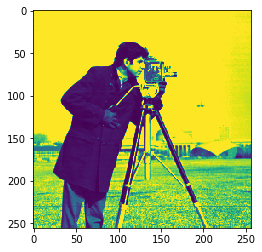

In [19]:
gray = img_bgr.copy()
gray = gray.astype('float32')

intensity_shift = 100
gray += intensity_shift

gray = np.clip(gray, 0, 255)

gray = gray.astype('uint8')
plt.imshow(gray)

--- 0.301804780960083 seconds ---


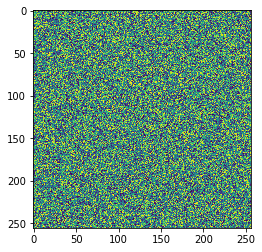

In [20]:
start_time = time.time()
bright_encImg = homomorphicBrightness(publickey, encImg, 100)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(bright_encImg.astype(np.float))


--- 86.83373975753784 seconds ---


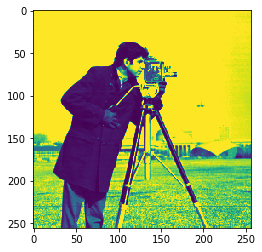

In [21]:
start_time = time.time()
bright_decImg = ImgDecrypt(publickey, privatekey, bright_encImg)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(bright_decImg)

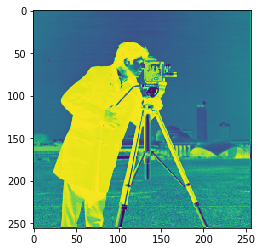

In [22]:
height, width = img_bgr.shape
neg_img = img_bgr.copy()

for i in range(0, height - 1):
    for j in range(0, width - 1):
        pixel = img_bgr[i, j]
        pixel = 255 - pixel
        neg_img[i, j] = pixel

plt.imshow(neg_img)

--- 48.83317494392395 seconds ---


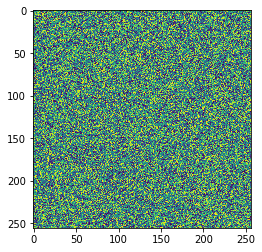

In [23]:
def homomorphic_negation(publickey, encImg):    
    shape = encImg.shape
    neg_encImg = encImg.flatten().tolist()
    maximum = Encrypt(publickey, 255)
    neg_encImg = [homomorphic_add(publickey, maximum, multiplicative_inverse(pix, publickey.nsq)) for pix in neg_encImg]
    return np.asarray(neg_encImg).reshape(shape)

start_time = time.time()
neg_encImg = homomorphic_negation(publickey, encImg) 
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(bright_decImg)
plt.imshow(neg_encImg.astype(np.float))

--- 94.86048698425293 seconds ---


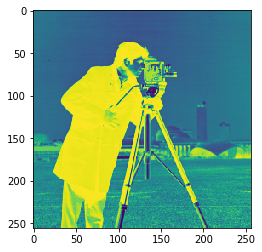

In [24]:
start_time = time.time()
neg_decImg = ImgDecrypt(publickey, privatekey, neg_encImg)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(neg_decImg)

In [25]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [26]:
calculate_psnr(neg_img, neg_decImg)

31.900382865340646

In [27]:
calculate_psnr(gray, bright_decImg)

inf

In [28]:
def calculate_mse(img1,img2):
    return np.mean((img1 - img2)**2)

In [29]:
calculate_mse(neg_img, neg_decImg)

41.97996520996094

In [30]:
calculate_mse(gray, bright_decImg)

0.0

In [31]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [32]:
calculate_ssim(neg_img, neg_decImg)

0.9998825031822526

In [33]:
calculate_ssim(gray, bright_decImg)

1.0